# Conditional Variational Autoencoder

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
PATH = "data/"
file_name = PATH + "mnist_train.csv"

In [3]:
df = pd.read_csv(file_name)

In [4]:
X = df.iloc[:, 1:].values
X = X.astype("float32")
X = X.reshape((len(X), 1, 28, 28))
X = X / 255
X.shape

(60000, 1, 28, 28)

In [5]:
Y = df.iloc[:, 0].values

In [6]:
batch_size = 1024
seed = 42
device = "cuda"

In [7]:
class MnistDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float().to(device)
        self.Y = torch.from_numpy(Y).long().to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx, :, :, :], self.Y[idx]

In [8]:
def kl_normal(mu, sd):
    # Assume prior ~ N(0, 1)
    prior = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(sd))
    posterior = torch.distributions.Normal(mu, sd)
    return torch.distributions.kl.kl_divergence(posterior, prior)

class BatchConvTranspose(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=0):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, padding=padding,
                                       kernel_size=kernel_size, stride=2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class BatchConv(nn.Module):
    def __init__(self, in_channels, out_channels, padding=0, kernel_size=3, stride=2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding,
                              kernel_size=kernel_size, stride=stride, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [9]:
class CVAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()

        self.z_dim = z_dim

        self.conv_1 = BatchConv(1, 16)
        self.conv_2 = BatchConv(16, 32)
        self.conv_3 = BatchConv(32, 64)
        self.conv_4 = nn.Conv2d(64, 2 * self.z_dim, kernel_size=2, stride=1)

        self.deconv_1 = BatchConvTranspose(self.z_dim, 32)
        self.deconv_2 = BatchConvTranspose(32, 16)
        self.deconv_3 = BatchConvTranspose(16, 8)
        self.deconv_4 = BatchConvTranspose(8, 4, kernel_size=2, padding=1)
        self.decoder_label_embedding = nn.Embedding(10, self.z_dim)

        self.conv_output = nn.Conv2d(4, 1, kernel_size=3, stride=1, padding=1)
        self.act = nn.Sigmoid()

    def encoder(self, input_, target):
        x = self.conv_1(input_)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)

        mu = x[:, 0:self.z_dim, 0, 0]

        # Want sd > 0
        sd = x[:, self.z_dim : 2 * self.z_dim, 0, 0]
        sd = F.softplus(sd)
        return mu, sd

    def decoder(self, z):
        x = self.deconv_1(z)
        x = self.deconv_2(x)
        x = self.deconv_3(x)
        x = self.deconv_4(x)

        x = self.conv_output(x)
        x = self.act(x)
        return x

    def forward(self, input_, target):
        mu, sd = self.encoder(input_, target)

        kl_loss = kl_normal(mu, sd)
        kl_loss = torch.sum(kl_loss) / len(input_)

        # Reparameterization trick
        z = mu + torch.randn((len(input_), self.z_dim), device=device) * sd
        z += self.decoder_label_embedding(target)
        z = z.unsqueeze(2).unsqueeze(2)

        x_hat = self.decoder(z)
        output_target = input_ > 0.5
        output_target = output_target.float()

        # log likelihood = -cross entropy
        expected_log_likelihood = -F.binary_cross_entropy(x_hat, output_target, reduction="sum") / len(input_)
        return expected_log_likelihood, kl_loss

    def sample(self, target, num_samples):
        mu = torch.zeros((num_samples, self.z_dim), device=device)
        sd = torch.ones((num_samples, self.z_dim), device=device)

        z = mu + torch.randn((num_samples, self.z_dim), device=device) * sd
        z += self.decoder_label_embedding(target)
        z = z.unsqueeze(2).unsqueeze(2)

        x_hat = self.decoder(z)
        return x_hat

In [10]:
dataset = MnistDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0)

In [11]:
z_dim = 64

torch.manual_seed(seed)
model = CVAE(z_dim).to(device)

In [12]:
lr = 1e-2
epochs = 200

optimizer = optim.Adam(model.parameters(), lr=lr)

In [13]:
loss_list = []

np.random.seed(seed)
torch.manual_seed(seed)
model.train()

for epoch in range(epochs):
    epoch_loss = 0.0
    for _, (x, y) in enumerate(dataloader):
        #print("tt")
        model.zero_grad()

        expected_log_likelihood, kl_loss = model(x, y)
        elbo = -(expected_log_likelihood - kl_loss) # Want to maximize elbo, i.e. minimize -elbo
        elbo.backward()
        optimizer.step()

        epoch_loss += elbo.detach().cpu().numpy()
    loss_list.append(epoch_loss / len(dataloader))
    
    if epoch % 10 == 0:
        print(f"------ Epoch {epoch} ------")
        print(f"Loss: {epoch_loss / len(dataloader)}")

------ Epoch 0 ------
Loss: 206.21737205376058
------ Epoch 10 ------
Loss: 102.89933065640724
------ Epoch 20 ------
Loss: 94.62510370804091
------ Epoch 30 ------
Loss: 91.5261340383756
------ Epoch 40 ------
Loss: 89.66650054414393
------ Epoch 50 ------
Loss: 88.36953489659196
------ Epoch 60 ------
Loss: 87.54937782934157
------ Epoch 70 ------
Loss: 86.98727985963983
------ Epoch 80 ------
Loss: 86.37666126833123
------ Epoch 90 ------
Loss: 85.94325295141188
------ Epoch 100 ------
Loss: 85.52257175768835
------ Epoch 110 ------
Loss: 85.30696571479409
------ Epoch 120 ------
Loss: 84.79723733158436
------ Epoch 130 ------
Loss: 84.68082699533237
------ Epoch 140 ------
Loss: 84.41297266038798
------ Epoch 150 ------
Loss: 84.23096841068592
------ Epoch 160 ------
Loss: 83.95675607454979
------ Epoch 170 ------
Loss: 83.83496042025291
------ Epoch 180 ------
Loss: 83.58834800073656
------ Epoch 190 ------
Loss: 83.43438449148404


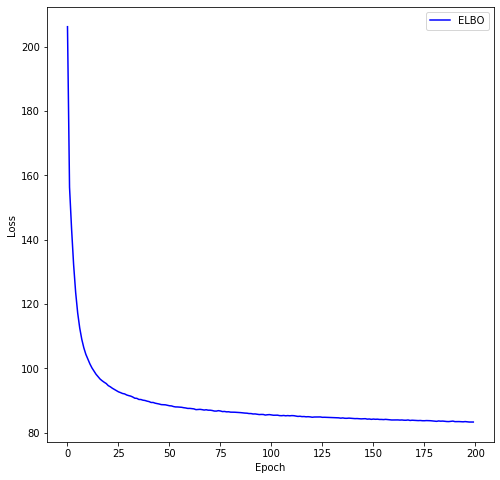

In [14]:
plt.figure(figsize=(8, 8))
plt.plot(loss_list, "b", label="ELBO")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [15]:
torch.manual_seed(seed)
model.eval()

num_samples = 9
target_samples = torch.randint(low=0, high=10, size=(num_samples,), device=device)

generated_images = model.sample(target_samples, num_samples=num_samples)
generated_images = generated_images[:, 0, :, :].detach().cpu().numpy()

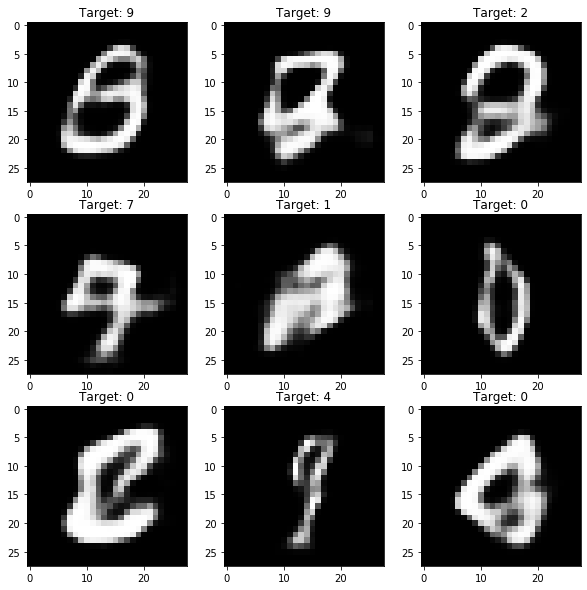

In [16]:
# Fake images
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        ax[i, j].imshow(generated_images[i*3 + j, :, :], cmap="gray")
        ax[i, j].set_title("Target: " + str(target_samples[i*3 + j].cpu().numpy()))
plt.show()

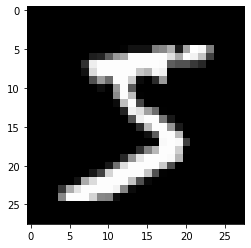

In [17]:
# Real image
plt.imshow(X[0, :].reshape(28, 28), cmap="gray")
plt.show()